In [1]:
import numpy as np, pandas as pd
import os
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import requests
import sqlite3 as sql
import json
from bs4 import BeautifulSoup
import json
from PIL import Image

In [2]:
tmdb_api_key = '54fa6d1f8872b5bc6b60d95ba18f98a2'

data_loc = 'C:\\users\\tomdevine\\Desktop\\Projects\\Personal_Projects\\Data'
data_loc = '/Users/tomdevine/dev/python/Projects/PersonalProjects/Data'
letterboxd_exports_folder = os.path.join(data_loc, 'LetterboxdExports')
letterboxd_user_name = 'td1138'
latest_date = datetime.datetime.strptime('20200101', '%Y%m%d')

db_name = 'lb-film.db'
film_db_path = os.path.join(data_loc, db_name)

for i in os.listdir(letterboxd_exports_folder):
    if i[0] != '.':
        tmp = i.replace('letterboxd-'+letterboxd_user_name+'-', '')
        tmp_parsed = datetime.datetime.strptime(tmp, '%Y-%m-%d-%H-%M-%Z')
        if tmp_parsed > latest_date:
            latest_date = tmp_parsed
print('latest_export_date = {}'.format(datetime.datetime.strftime(latest_date, '%Y-%m-%d %H:%M')))

latest_export_filename = 'letterboxd-' + letterboxd_user_name + '-' + datetime.datetime.strftime(latest_date, '%Y-%m-%d-%H-%M-%Z')+'utc'
latest_export_file_loc = os.path.join(letterboxd_exports_folder, latest_export_filename)
print('Latest export file location - {}'.format(latest_export_file_loc))

latest_export_date = 2022-07-05 13:32
Latest export file location - /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/LetterboxdExports/letterboxd-td1138-2022-07-05-13-32-utc


## Let's define some functions for interacting with our database:

In [3]:
def db_info(db_path):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    db_conn = sql.connect(db_path)
    connection_cursor = db_conn.cursor()
    tables = connection_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    if len(tables) == 0:
        print('This database has no tables yet!')
    else:
        for table_name in tables:
            table_name = table_name[0] # tables is a list of single item tuples
            table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), db_conn)
            print(table_name)
            for col in table.columns:
                print('\t' + col)
    db_conn.close()
    return None

In [4]:
def df_to_table(df, db_path, table_name, replace_append='replace'):
    db_conn = sql.connect(db_path)
    try:
        df.columns = [col.upper() for col in df.columns]
        df.to_sql(table_name, db_conn, if_exists=replace_append, index=False)
        db_conn.close()
        print('dataframe succesfully added to the database {} with the table name {}'.format(db_path, table_name))
    except:
        db_conn.close()
        print('Error - dataframe couldn\'t be added to the database')

In [5]:
def drop_table(db_path, table_name):
    db_conn = sql.connect(db_path)
    try:
        drop_statement = 'DROP TABLE {}'.format(table_name)
        db_conn.cursor().execute(drop_statement)
        db_conn.close()
        return print('Table {} dropped successfully'.format(table_name))
    except:
        db_conn.close()
        return print('Error in dropping the table')

In [6]:
def table_to_df(db_path, table_name):
    db_conn = sql.connect(db_path)
    select_statement = 'SELECT * FROM {}'.format(table_name)
    df = pd.read_sql(select_statement, db_conn)
    db_conn.close()
    return df

In [7]:
db_info(film_db_path)

WATCHED
	FILM_ID
	FILM_NAME
	FILM_YEAR
	LETTERBOXD_URI
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH
RANKING
	FILM_ID
	FILM_POSITION


In [8]:
def convert_uri_to_id(letterboxd_uri):
    return 'f_'+letterboxd_uri.replace('https://boxd.it/', '').zfill(5)

In [9]:
# This is every film I've ever watched - this will form a perfect basis for scraping the metadata for our movie database.
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df['FILM_ID'] = watched_df['Letterboxd URI'].apply(convert_uri_to_id)
watched_df.columns = ['DATE', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watched_df = watched_df[['FILM_ID', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI']]
watched_df

,FILM_ID,FILM_NAME,FILM_YEAR,LETTERBOXD_URI
0,f_01ZLI,Jumanji,1995,https://boxd.it/1ZLI
1,f_01UTC,Fatal Attraction,1987,https://boxd.it/1UTC
2,f_020E4,Punch-Drunk Love,2002,https://boxd.it/20E4
3,f_01TBi,Altered States,1980,https://boxd.it/1TBi
4,f_03z48,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48
...,...,...,...,...
2084,f_01KQ4,Carnival of Souls,1962,https://boxd.it/1KQ4
2085,f_01R2q,Split Second,1992,https://boxd.it/1R2q
2086,f_01XZS,The Wicker Man,2006,https://boxd.it/1XZS
2087,f_026vi,In the Mouth of Madness,1994,https://boxd.it/26vi


In [10]:
df_to_table(watched_df, film_db_path, 'WATCHED')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name WATCHED


In [11]:
diary_df_raw = pd.read_csv(os.path.join(latest_export_file_loc, 'diary.csv'))
diary_df_raw = diary_df_raw[['Watched Date', 'Name', 'Year', 'Rating', 'Rewatch', 'Tags']]
diary_df_raw.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'FILM_RATING', 'REWATCH', 'TAGS']
diary_df = diary_df_raw.merge(watched_df, how='left', left_on=['FILM_NAME', 'FILM_YEAR'], right_on=['FILM_NAME', 'FILM_YEAR'])
diary_df['FIRST_TIME_WATCH'] = np.where(diary_df['REWATCH']=='Yes', 0, 1)
diary_df['REWATCH'] = np.where(diary_df['REWATCH']=='Yes', 1, 0)
diary_df['TAGS'] = diary_df['TAGS'].fillna('')
diary_df['TAG_COUNT'] = diary_df['TAGS'].apply(lambda x: 1+x.count(','))
diary_df_output = diary_df[['FILM_ID', 'WATCH_DATE', 'FILM_RATING', 'TAGS', 'FIRST_TIME_WATCH']]
diary_df_output

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
0,f_01ZLI,2021-01-01,2.5,,1
1,f_01UTC,2021-01-01,4.0,,1
2,f_020E4,2021-01-02,3.5,physicalmedia,1
3,f_01TBi,2021-01-02,4.0,physicalmedia,1
4,f_03z48,2021-01-02,4.0,bbciplayer,1
...,...,...,...,...,...
686,f_01XZS,2022-06-30,3.0,primevideo,1
687,f_0294O,2022-07-01,5.0,physicalmedia,0
688,f_026vi,2022-07-01,4.0,vod,1
689,f_020lm,2022-07-03,4.5,physicalmedia,0


In [12]:
df_to_table(diary_df_output, film_db_path, 'DIARY')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name DIARY


In [13]:
db_info(film_db_path)

RANKING
	FILM_ID
	FILM_POSITION
WATCHED
	FILM_ID
	FILM_NAME
	FILM_YEAR
	LETTERBOXD_URI
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH


In [14]:
ranking_list = pd.read_csv(os.path.join(latest_export_file_loc, 'lists/every-film-ranked-experiment.csv'), skiprows=3)
ranking_list['film_id'] = ranking_list['URL'].apply(convert_uri_to_id)
ranking_list.columns = ['FILM_POSITION', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'DESCRIPTION', 'FILM_ID']
ranking_list['FILM_POSITION'] = ranking_list['FILM_POSITION'].astype('Int64')
ranking_list_output = ranking_list[['FILM_ID', 'FILM_POSITION']]
ranking_list_output

,FILM_ID,FILM_POSITION
0,f_027US,1
1,f_027Vw,2
2,f_027Vm,3
3,f_0072s,4
4,f_02aA2,5
...,...,...
490,f_01a1u,491
491,f_037n2,492
492,f_01TWq,493
493,f_01c3M,494


In [15]:
df_to_table(ranking_list_output, film_db_path, 'RANKING')

dataframe succesfully added to the database /Users/tomdevine/dev/python/Projects/PersonalProjects/Data/lb-film.db with the table name RANKING


In [16]:
diary_df = diary_df.merge(ranking_list_output[['FILM_ID', 'FILM_POSITION']], how='left', on='FILM_ID')
diary_df['NARRATIVE_FEATURE'] = np.where(diary_df['FILM_POSITION'].isnull(), 0, 1)
feature_diary_df = diary_df[diary_df['NARRATIVE_FEATURE']==1].reset_index(drop=True)

In [17]:
feature_diary_df

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,400,1
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,166,1
2,2021-01-02,Punch-Drunk Love,2002,3.5,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,285,1
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,102,1
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,327,1
...,...,...,...,...,...,...,...,...,...,...,...,...
496,2022-06-30,The Wicker Man,2006,3.0,0,primevideo,f_01XZS,https://boxd.it/1XZS,1,1,291,1
497,2022-07-01,The Thing,1982,5.0,1,physicalmedia,f_0294O,https://boxd.it/294O,0,1,6,1
498,2022-07-01,In the Mouth of Madness,1994,4.0,0,vod,f_026vi,https://boxd.it/26vi,1,1,130,1
499,2022-07-03,They Live,1988,4.5,1,physicalmedia,f_020lm,https://boxd.it/20lm,0,1,53,1


In [18]:
tmp = feature_diary_df.groupby('FILM_RATING').agg({'FILM_POSITION':['min', 'max', 'count']}).reset_index()
tmp.columns = ['RATING_QUANT', 'MIN_POSITION', 'MAX_POSITION', 'FILM_COUNT']
tmp

,RATING_QUANT,MIN_POSITION,MAX_POSITION,FILM_COUNT
0,0.5,495,495,1
1,1.0,478,494,17
2,1.5,451,477,27
3,2.0,431,450,20
4,2.5,380,430,51
5,3.0,291,379,90
6,3.5,200,290,92
7,4.0,87,199,115
8,4.5,29,86,59
9,5.0,1,28,29


In [19]:
ratings_dict = {}
for rating in sorted(feature_diary_df['FILM_RATING'].unique(), reverse=True):
    tmp_df = feature_diary_df[feature_diary_df['FILM_RATING']==rating]
    rating_count = len(tmp_df['FILM_NAME'].unique())
    increment = 0.5/rating_count
    highest_position = tmp_df['FILM_POSITION'].min()
    ratings_dict[rating] = {'RATING_COUNT':rating_count, 'INCREMENT':increment, 'MAX_POSITION':highest_position}
ratings_dict

{5.0: {'RATING_COUNT': 28,
  'INCREMENT': 0.017857142857142856,
  'MAX_POSITION': 1},
 4.5: {'RATING_COUNT': 56,
  'INCREMENT': 0.008928571428571428,
  'MAX_POSITION': 29},
 4.0: {'RATING_COUNT': 113,
  'INCREMENT': 0.004424778761061947,
  'MAX_POSITION': 87},
 3.5: {'RATING_COUNT': 91,
  'INCREMENT': 0.005494505494505495,
  'MAX_POSITION': 200},
 3.0: {'RATING_COUNT': 89,
  'INCREMENT': 0.0056179775280898875,
  'MAX_POSITION': 291},
 2.5: {'RATING_COUNT': 51,
  'INCREMENT': 0.00980392156862745,
  'MAX_POSITION': 380},
 2.0: {'RATING_COUNT': 20, 'INCREMENT': 0.025, 'MAX_POSITION': 431},
 1.5: {'RATING_COUNT': 27,
  'INCREMENT': 0.018518518518518517,
  'MAX_POSITION': 451},
 1.0: {'RATING_COUNT': 17,
  'INCREMENT': 0.029411764705882353,
  'MAX_POSITION': 478},
 0.5: {'RATING_COUNT': 1, 'INCREMENT': 0.5, 'MAX_POSITION': 495}}

In [20]:
def scale_rating(basic_rating, position):
    dict_entry = ratings_dict[basic_rating]
    relative_position = position - dict_entry['MAX_POSITION']
    required_increment = relative_position*dict_entry['INCREMENT']
    final_rating = basic_rating - required_increment
    return final_rating

In [21]:
feature_diary_df['RATING_ADJUSTED'] = feature_diary_df.apply(lambda row: scale_rating(row['FILM_RATING'], row['FILM_POSITION']), axis=1)
feature_diary_df.head()

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_ADJUSTED
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,400,1,2.303922
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,166,1,3.650442
2,2021-01-02,Punch-Drunk Love,2002,3.5,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,285,1,3.032967
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,102,1,3.933628
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,327,1,2.797753


In [22]:
feature_diary_df[feature_diary_df['WATCH_DATE']<='2021-12-31']

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_ADJUSTED
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,400,1,2.303922
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,166,1,3.650442
2,2021-01-02,Punch-Drunk Love,2002,3.5,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,285,1,3.032967
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,102,1,3.933628
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,327,1,2.797753
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,2021-12-29,Body Melt,1993,2.5,0,shudder,f_01AxQ,https://boxd.it/1AxQ,1,1,420,1,2.107843
341,2021-12-29,The Brain Eaters,1958,1.5,0,youtube,f_00zzE,https://boxd.it/zzE,1,1,476,1,1.037037
342,2021-12-30,Encanto,2021,2.5,0,disney+,f_0kPRu,https://boxd.it/kPRu,1,1,380,1,2.500000
343,2021-12-31,Muppet Treasure Island,1996,3.0,0,disney+,f_01VaS,https://boxd.it/1VaS,1,1,324,1,2.814607


In [23]:
def barplot_mean(df, group_col, mean_col, minimum_grouping_count=None):
    df[group_col] = df[group_col].astype(str)
    tmp = df.groupby(group_col).agg({mean_col:['mean', 'count']}).reset_index()
    tmp = tmp[tmp[group_col] != '']
    tmp.columns = ['_'.join(col) if col[0] != group_col else col[0] for col in tmp.columns]
    if minimum_grouping_count is not None:
        tmp = tmp[tmp[mean_col+'_count']>=minimum_grouping_count]
    tmp = tmp.sort_values(mean_col+'_mean', ascending=False)
    tmp[mean_col+'_count'] = tmp[mean_col+'_count'].astype('float64')
    tmp_plot = sns.barplot(data=tmp, y=group_col, x=mean_col+'_mean', hue=mean_col+'_count', dodge=False, palette='Blues')
    plt.title('mean ' + mean_col + ' grouped by ' + group_col)
    return plt.show()

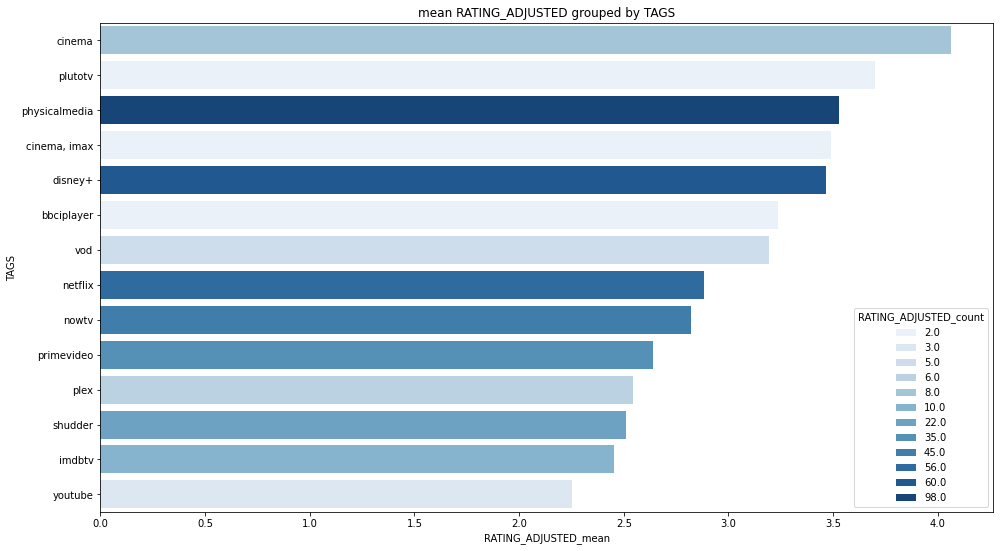

In [24]:
fig = plt.figure(figsize=(16,9))

barplot_mean(feature_diary_df, 'TAGS', 'RATING_ADJUSTED', 2)

In [27]:
from tmdbv3api import TMDb
tmdb = TMDb()
tmdb.api_key = tmdb_api_key

In [28]:
from tmdbv3api import Movie
movie = Movie()

m = movie.details(603)

print(m.title)
print(m.overview)
print(m.popularity)

The Matrix
Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.
74.981


In [ ]:
required_keys = ['adult',
                 'title',
                 'budget',
                 'genres',
                 'original_language',
                 'original_title',
                 'poster_path',
                 'production_countries',
                 'release_date',
                 'revenue',
                 'runtime',
                 'casts']

In [34]:
'https://image.tmdb.org/t/p/original' + '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

'https://image.tmdb.org/t/p/original/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

In [33]:
for k in m.keys():
    print('\n{} = {}'.format(k, m[k]))


adult = False

backdrop_path = /y9wuhlrqSHvhTLNVNwKMKe6HZzY.jpg

belongs_to_collection = {'id': 2344, 'name': 'The Matrix Collection', 'poster_path': '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg', 'backdrop_path': '/bRm2DEgUiYciDw3myHuYFInD7la.jpg'}

budget = 63000000

genres = [{'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]

homepage = http://www.warnerbros.com/matrix

id = 603

imdb_id = tt0133093

original_language = en

original_title = The Matrix

overview = Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.

popularity = 74.981

poster_path = /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg

production_companies = [{'id': 79, 'logo_path': '/tpFpsqbleCzEE2p5EgvUq6ozfCA.png', 'name': 'Village Roadshow Pictures', 'origin_country': 'US'}, {'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOIDdWRKSEJ.png', 'name': 'Warner Bros. Pictures', 'origin_country': 'US'}, {'i

'The Matrix'

In [30]:
m.runtime

136

In [32]:
def tmdb_info(tmdb_movie_id):
    movie = Movie()
    response = movie.details(tmdb_movie_id)
    print(response.)

SyntaxError: invalid syntax (Temp/ipykernel_28108/4152308338.py, line 4)

In [ ]:
def letterboxd(url, verbose=False):
    headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
    if verbose: print('URL requested was {}'.format(url))
    r = requests.get(url, headers=headers)
    redirected_url = r.url
    if verbose and (url != redirected_url):
        print('Final redirected URL was {}'.format(redirected_url))
    r = requests.get(redirected_url, headers=headers)
    content_string = str(r.content)
    soup = BeautifulSoup(r.content, 'lxml')

    item = {}
    
    title = soup.find('meta', {'property': 'og:title'}).get('content')
    cast = [cast.text for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    characters = [str(cast)[str(cast).find('title=')+7:str(cast).find(">")-1] for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    directors = [directors.text for directors in soup.find_all('span', {'class': 'prettify'})]
    rating = soup.find('meta', {'name': 'twitter:data2'}).get('content')
    directors = soup.find_all('div', {'class': 'text-sluglist'})[1]
    directors = [directors.text for directors in directors.find_all('a')]
    producers = soup.find_all('div', {'class': 'text-sluglist'})[2]
    producers = [producers.text for producers in producers.find_all('a')]
    writers = soup.find_all('div', {'class': 'text-sluglist'})[3]
    writers = [writers.text for writers in writers.find_all('a')]
    editors = soup.find_all('div', {'class': 'text-sluglist'})[4]
    editors = [editors.text for editors in editors.find_all('a')]
    cinematographers = soup.find_all('div', {'class': 'text-sluglist'})[5]
    cinematographers = [cinematographers.text for cinematographers in cinematographers.find_all('a')]
    composers = soup.find_all('div', {'class': 'text-sluglist'})[10]
    composers = [composers.text for composers in composers.find_all('a')]
    studios = soup.find_all('div', {'class': 'text-sluglist'})[14]
    studios = [studios.text for studios in studios.find_all('a')]
    countries = soup.find_all('div', {'class': 'text-sluglist'})[15]
    countries = [countries.text for countries in countries.find_all('a')]
    languages = soup.find_all('div', {'class': 'text-sluglist'})[16]
    languages = [languages.text for languages in languages.find_all('a')]
    genres = soup.find_all('div', {'class': 'text-sluglist'})[17]
    genres = [genres.text for genres in genres.find_all('a')]
    themes = soup.find_all('div', {'class': 'text-sluglist'})[18]
    themes = [themes.text for themes in themes.find_all('a')]
    
    
    year = soup.find('small', {'class': 'number'}).text
    
    film_length_start = content_string[content_string.find('<p class="text-link text-footer">')+57:]
    film_length = film_length_start[:film_length_start.find('&nbsp')]
    lazy_load_pos = content_string.find('really-lazy-load poster')
    img_src_0 = lazy_load_pos + content_string[lazy_load_pos:].find('<img src="') + 10
    img_src_1 = img_src_0 + content_string[img_src_0:].find('"')
    img_url = content_string[img_src_0:img_src_1]
    
    
    id_loc_0 = content_string.find('id: ') + 4
    id_loc_1 = content_string.find(',', id_loc_0)
    film_id = 'id_'+content_string[id_loc_0:id_loc_1].zfill(9)
    
    item['unique_id'] = film_id
    item['title'] = title
    item['release_year'] = year
    item['film_length'] = film_length
    item['director'] = directors
    item['cast'] = cast
    item['characters'] = characters
    item['rating'] = rating
    item['genres'] = genres
    item['producers'] = producers
    item['writers'] = writers
    item['editors'] = editors
    item['cinematographers'] = cinematographers
    item['composers'] = composers
    item['studios'] = studios
    item['countries'] = countries
    item['languages'] = languages
    item['themes'] = themes
    
    item['imgurl'] = img_url
    
    og_url = soup.find('meta', {'property': 'og:url'}).get('content')
    film = og_url.split('/')[-2]

    r = requests.get('https://letterboxd.com/esi/film/{}/stats/'.format(film), headers=headers)

    soup2 = BeautifulSoup(r.content, 'lxml')


    watched_by = str(soup2)[str(soup2).find('Watched by ')+11:str(soup2).find('Watched by ')+25]
    watched_by = int(watched_by[0:watched_by.find('\xa0m')].replace(',',''))
    
    listed_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    listed_by = int(listed_by[0:listed_by.find('\xa0l')].replace(',',''))
    
    liked_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    liked_by = int(liked_by[0:liked_by.find('\xa0l')].replace(',',''))
    
    top_ = int(soup2.find('a', {'class': 'has-icon icon-top250 icon-16 tooltip'}).text)

    item['watch_count'] = watched_by
    item['list_count'] = listed_by
    item['like_count'] = liked_by
    item['top250'] = top_
    item['datacollection_timestamp'] = datetime.datetime.now()
    
    return item

test_film = letterboxd('https://letterboxd.com/film/the-matrix/')
test_film

In [ ]:
url = 'https://letterboxd.com/film/the-matrix/'
headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
r = requests.get(url, headers=headers)
redirected_url = r.url
if (url != redirected_url):
    print('Final redirected URL was {}'.format(redirected_url))
r = requests.get(redirected_url, headers=headers)
content_string = str(r.content)

In [ ]:
#cinematographers = 
BeautifulSoup(r.content, 'lxml').find_all('p', {'class': 'text-link text-footer'})[0].find_all('a')




In [ ]:
print(content_string[:666])

In [ ]:
len('<div class="text-sluglist capitalize"')

In [ ]:
content_string.find() #_all('/films/theme/')

In [ ]:
text_upto = content_string[content_string.find('<div class="text-sluglist capitalize"'):]
text = text_upto[:text_upto.find('&nbsp')]
text_upto

In [ ]:
def grab_img_from_url(url, resize=True, output_size=(256, 256), display_img=False):
    image = Image.open(requests.get(url, stream=True).raw)
    if resize:
        image.thumbnail(output_size)
    if display_img:
        display(image)
    return image

In [ ]:
def save_img(pil_img, save_loc):
    try:
        pil_img.save(save_loc)
        return print('Save Successful')
    except:
        return print('Save Unsuccessful')

In [ ]:
file_loc = os.path.join(data_loc, 'Posters', 'matrix'+'.jpeg')

In [ ]:
tmp_img = grab_img_frozm_url(test_film['imgurl'], resize=True)

In [ ]:
tmp_img

In [ ]:
save_img(tmp_img, file_loc)

In [ ]:
#[
[j.find('div').find('really-lazy-load poster film-poster film-poster-51518') for j in i.children]# for i in soup.find_all('div')]





In [ ]:
soup